# Graph Neural Network

## Importing

In [1]:
from selfdist_toolkit.pyg_tools import gnn_load, GIN_nn, execution, sd_utils, accuracy
import pandas as pd
import torch
import torch_geometric
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

C:\Users\johan\anaconda3\envs\praktikum\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Loading aid_list

In [2]:
aid_list = pd.read_csv("results/random_forest/experiments_check/chem-desc_good-aid_1.csv").aid.to_numpy().astype(int)

In [3]:
aid_list

array([    884,     891,     899,     914,    1418,    1431,    1770,
          1771,    1795,  493073,  493102,  493177,  493191,  493240,
        588834,  651741,  651812,  651814,  686978,  687022,  720691,
        743036,  743040,  743065, 1053173, 1259381, 1346982])

In [4]:
# for one aid now
aid = 914# aid_list[0]
random_state = 131313

## Select mode: smooth for 2 dim label and hard for 1-dim label

In [5]:
# mode = "smooth"
mode = "hard"

## Load pytorch data

In [6]:
whole_data = gnn_load.load_pyg_data_aid(aid=aid, label_type=mode, do_in_parallel=True)

In [7]:
whole_data[:4]

[Data(x=[13, 9], edge_index=[2, 28], edge_attr=[28, 3], smiles='CNCCC1=CNC2=CC=CC=C21', y=[1]),
 Data(x=[21, 9], edge_index=[2, 40], edge_attr=[40, 3], smiles='CCCCCCCCCCCCCCCC(C(CO)N)O', y=[1]),
 Data(x=[25, 9], edge_index=[2, 56], edge_attr=[56, 3], smiles='C[C@]12CCC(=O)C=C1CC[C@@H]3[C@@H]2CC[C@]4([C@H]3CC[C@@]4(C(=O)CO)O)C', y=[1]),
 Data(x=[19, 9], edge_index=[2, 42], edge_attr=[42, 3], smiles='C1=CC=C(C=C1)C2=NC3=CC=CC=C3C(=C2)C(=O)O', y=[1])]

In [8]:
# build labels for split
labels_hard = np.array([
    data.y.detach().cpu().numpy()
    for data in whole_data
]).flatten().astype(int)

In [9]:
labels_hard.shape

(7340,)

In [10]:
labels_hard.sum()

216

In [11]:
# data splitting
for train_idx, test_idx in StratifiedShuffleSplit(n_splits=1, random_state=random_state, test_size=0.2).split(whole_data, labels_hard):
    break

In [12]:
labels_hard[train_idx].sum()/len(train_idx)

0.029461852861035424

In [13]:
labels_hard[test_idx].sum()/len(test_idx)

0.029291553133514985

In [14]:
# create the data loader
dl_train = torch_geometric.loader.DataLoader([whole_data[idx] for idx in train_idx], batch_size=100)
dl_test = torch_geometric.loader.DataLoader([whole_data[idx] for idx in test_idx], batch_size=100)

## Instantiate model

In [15]:
# GNN model
model = GIN_nn.GIN_basic(1, jk="cat")

In [16]:
# loss
loss = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([len(train_idx)/labels_hard[train_idx].sum()]))

In [17]:
# device
device = torch.device('cuda')

In [18]:
device

device(type='cuda')

In [19]:
model = model.to(device)
loss = loss.to(device)

In [20]:
# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Train model

In [31]:
# training:
execution.training(model, dl_train, device, optimizer, loss)

100%|██████████| 59/59 [00:02<00:00, 29.04it/s]


0.6914166

## Testing model

In [32]:
# testing:
pred_hard = execution.predict(model, dl_test, device, reduce_to_hard_label=True)

100%|██████████| 15/15 [00:00<00:00, 33.34it/s]


In [33]:
pred_hard.sum()/pred_hard.shape[0]

0.39373297002724794

In [46]:
y_true = np.array([whole_data[idx].y.numpy() for idx in test_idx]).flatten()

In [47]:
print(y_true.shape)
print(pred_hard.shape)

(1468,)
(1468,)


In [48]:
from sklearn.metrics import roc_auc_score

In [49]:
roc_auc_score(y_true=y_true, y_score=pred_hard)

0.776344349245206

In [50]:
roc_auc_score(y_true=y_true, y_score=pred_hard, average="weighted")

0.776344349245206

In [31]:
for batch in dl_train:
    break

In [32]:
batch

DataBatch(x=[2428, 9], edge_index=[2, 5266], edge_attr=[5266, 3], smiles=[100], y=[100], batch=[2428], ptr=[101])

In [33]:
batch = batch.to(device)

In [34]:
pred = model(batch).flatten()

In [35]:
loss.to(device)

BCEWithLogitsLoss()

In [36]:
loss(pred, batch.y)

tensor(1.3406, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

In [37]:
pred_hard[:5]

array([0, 0, 0, 1, 0])

In [38]:
# true labels
pred_hard_true = np.array([data.y.numpy().astype(int) for data in [whole_data[idx] for idx in test_idx]]).flatten()

In [39]:
pred_hard_true[:5]

array([0, 0, 0, 0, 0])

In [40]:
# get accuracy scores
acc = accuracy.calculate_accuracies_1d(y_true=pred_hard_true, y_pred=pred_hard)

In [41]:
acc.to_dict()

{'accuracy_score': 0.7445504087193461,
 'balanced_accuracy': 0.7894818441452469,
 'roc_score': 0.7894818441452469,
 'precision': 0.9669323454825047,
 'recall': 0.7445504087193461}

In [43]:
df = acc.to_df(index=1)

In [51]:
df_temp = pd.concat([df, df], axis=1, keys=['training', 'testing'])
df_temp.head()

training                                                 \
  accuracy_score balanced_accuracy roc_score precision   recall   
1        0.74455          0.789482  0.789482  0.966932  0.74455   

         testing                                                 
  accuracy_score balanced_accuracy roc_score precision   recall  
1        0.74455          0.789482  0.789482  0.966932  0.74455

In [52]:
df_temp.training

,accuracy_score,balanced_accuracy,roc_score,precision,recall
1,0.74455,0.789482,0.789482,0.966932,0.74455


In [55]:
df_temp.to_csv("test.csv")

In [61]:
df_load = pd.read_csv("test.csv", header=[0,1], index_col=[0])
df_load.head()

training                                                 \
  accuracy_score balanced_accuracy roc_score precision   recall   
1        0.74455          0.789482  0.789482  0.966932  0.74455   

         testing                                                 
  accuracy_score balanced_accuracy roc_score precision   recall  
1        0.74455          0.789482  0.789482  0.966932  0.74455

In [63]:
df_load.training.accuracy_score.to_numpy()

array([0.74455041])

## Self distillation elements

In [35]:
# define number_to_pick
number_to_pick = 100

In [ ]:
# load data for self distillation
selfdistillation_data = sd_utils.generate_gnn_sd_data(aid=aid)

In [78]:
# get good elements to insert into training pool for student model
selected, remaining = sd_utils.self_distillation_procedure_1dim(
    model=model, 
    self_distillation_data=selfdistillation_data, 
    number_to_pick=number_to_pick, 
    device=device, 
    correct_label=False, 
    batch_size=100
)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4455/4455 [01:02<00:00, 71.14it/s]


In [79]:
selected[:5]

[Data(x=[5, 9], edge_index=[2, 8], edge_attr=[8, 3], smiles='OS(=O)(=O)O', y=[1]),
 Data(x=[11, 9], edge_index=[2, 20], edge_attr=[20, 3], smiles='C(P(=O)(O)O)(P(=O)(O)O)(Cl)Cl', y=[1]),
 Data(x=[4, 9], edge_index=[2, 6], edge_attr=[6, 3], smiles='Cl[Sb](Cl)Cl', y=[1]),
 Data(x=[9, 9], edge_index=[2, 18], edge_attr=[18, 3], smiles='C1(=O)NC(=O)NC(=O)N1', y=[1]),
 Data(x=[5, 9], edge_index=[2, 8], edge_attr=[8, 3], smiles='CS(=O)(=O)O', y=[1])]

In [80]:
label_analysis = np.array([data.y.numpy() for data in selected])

In [81]:
label_analysis.sum()/label_analysis.shape[0]

1.4962436580390205e-07

In [82]:
selected2, remaining2 = sd_utils.self_distillation_procedure_1dim_advanced(
    model=model, 
    self_distillation_data=selfdistillation_data, 
    number_to_pick=number_to_pick, 
    pos_elem_to_pick_ratio=0.3,
    device=device, 
    correct_label=False, 
    batch_size=100
)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4455/4455 [01:00<00:00, 73.64it/s]


In [83]:
label_analysis2 = np.array([data.y.numpy() for data in selected2])

In [84]:
label_analysis2.sum()/label_analysis2.shape[0]

0.29977272033691404

In [ ]:
# todo: ausbauen auf viele epochen und student - teacher übergang. außerdem begutachten ob positive oder negative label bevorzugt werden sollten

## Whole iteration for a certain number of epochs

In [15]:
# GNN model
model = GIN_nn.GIN_basic(1)
# loss
loss = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([len(train_idx)/labels_hard[train_idx].sum()]))
# device
device = torch.device('cuda')
model = model.to(device)
loss = loss.to(device)
# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [16]:
# define number of epochs
epochs = 100

In [17]:
# define loss saving space
loss_storage = []

In [18]:
# define accuracy storage
accuracy_storage = []

In [19]:
# iterate over epochs
for epoch in tqdm(range(epochs)):
    
    # do training step
    loss_value = execution.training(model, dl_train, device, optimizer, loss, verbose=False)
    
    # put loss into storage
    loss_storage.append(loss_value)
    
    # do testing step
    y_pred_hard = execution.predict(model, dl_test, device, reduce_to_hard_label=True, verbose=False)
    
    # calculate accuracy DataFrame
    accuracy_storage.append(
        # get accuracy class and from it the DataFrame
        accuracy.calculate_accuracies_1d(
            y_pred=y_pred_hard, 
            y_true=accuracy.helper_pyg_to_numpy_label(
                data_loader=dl_test
            )
        ).to_df(index=epoch)
    )

# transform accuracy storage to pandas df
accuracy_storage = pd.concat(accuracy_storage)

# add new column for loss
accuracy_storage['loss'] = loss_storage

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [03:47<00:00,  2.28s/it]


In [20]:
accuracy_storage

,accuracy_score,balanced_accuracy,roc_score,precision,recall,loss
0,0.707084,0.781461,0.781461,0.967276,0.707084,1.075582
1,0.966621,0.497895,0.497895,0.942158,0.966621,0.932220
2,0.858311,0.791693,0.791693,0.965322,0.858311,0.857156
3,0.956403,0.582848,0.582848,0.953300,0.956403,0.806945
4,0.958447,0.640286,0.640286,0.958912,0.958447,0.799845
...,...,...,...,...,...,...
95,0.910763,0.818711,0.818711,0.967924,0.910763,0.306893
96,0.933924,0.819364,0.819364,0.969097,0.933924,0.261501
97,0.931880,0.818311,0.818311,0.968878,0.931880,0.221523
98,0.929837,0.817258,0.817258,0.968670,0.929837,0.260833


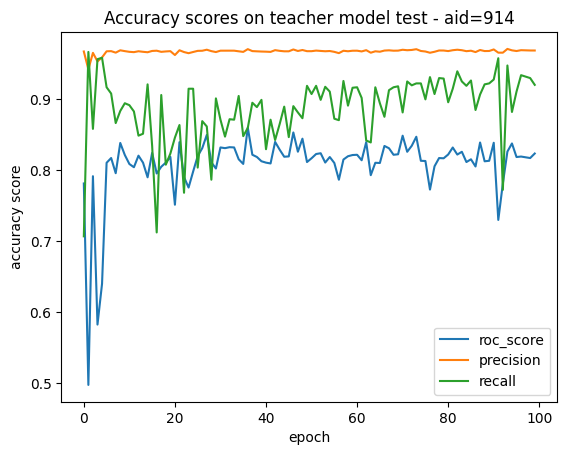

In [21]:
quality_zoom_factor = 1.
plt.figure(figsize=(6.4*quality_zoom_factor,4.8*quality_zoom_factor))
plt.plot(accuracy_storage.roc_score, label="roc_score")
plt.plot(accuracy_storage.precision, label="precision")
plt.plot(accuracy_storage.recall, label="recall")
plt.xlabel("epoch")
plt.ylabel("accuracy score")
plt.title("Accuracy scores on teacher model test - aid={}".format(aid))
plt.legend()
# plt.savefig('test.png', bbox_inches='tight')
plt.show()

In [67]:
# accuracy_storage.to_csv("test.csv", index=True, index_label="epoch")

## New self distillation

In [35]:
# get list of all molecules as pyg elements
all_molec_list = gnn_load.load_all_pyg()

In [36]:
# load all the smiles as string list
all_smiles = np.array([mol.smiles for mol in all_molec_list], dtype=str)

In [37]:
# get the aid smiles
aid_smiles = gnn_load.load_pure_data(aid).smiles.to_numpy().astype(str)

In [39]:
# get index of elements where the elements are not the same (new elements)
idx = np.where(np.invert(np.in1d(all_smiles, aid_smiles)))[0].tolist()

In [47]:
# get the items which are new
molec_list = list(map(all_molec_list.__getitem__, idx))
dl_sd = torch_geometric.loader.DataLoader(molec_list, batch_size=100)

In [43]:
# get prediction
sd_pred = execution.predict(model, dl_sd, device, reduce_to_hard_label=False, verbose=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4455/4455 [00:53<00:00, 83.48it/s]


In [51]:
df_sd = pd.DataFrame({
    "smiles": list(map(lambda x: x.smiles, molec_list)),
    "predicted_label_soft": sd_pred
})

In [52]:
df_sd

,smiles,predicted_label_soft
0,CC(CN)O,0.005720
1,C1=CC(=C(C=C1[N+](=O)[O-])[N+](=O)[O-])Cl,0.000042
2,C1=CC(=C(C(=C1)O)O)C(=O)O,0.000227
3,C(C=O)Cl,0.000382
4,C(CCl)O,0.009077
...,...,...
445481,C[C@]12C[C@@H]([C@H]3[C@H]([C@@H]1CC[C@@]2(C(=...,0.321223
445482,CC[N+]1(C2CC(CC1[C@@H]3[C@H]2O3)OC(=O)[C@H](CO...,0.053226
445483,[2H]C([2H])([2H])C(CCC[C@@H](C)[C@H]1CC[C@@H]\...,0.631370
445484,CC[C@@H]1[C@H](N2[C@H]3CC1C4[C@H]2C[C@]5([C@H]...,0.439120


In [54]:
# df_sd.to_csv("test.csv", index=False)